# Emulation of the TIP package using GPs

### J Gómez-Dans (NCEO/UCL)

This notebook demonstrates the emulation of bihemispherical reflectance using the two stream RT package from Pinty *et al.*. We make use of the [`gp_emulator` package](http://github.com/jgomezdans/gp_emulator) for this. We will produce an emulator for the visible and nir bands, and test emulator performance, as well as emulated gradient performance with respect to the original model. 

We make use of the Python bindings to the Two Stream model (see relevant README file).

In [1]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
%matplotlib inline

import gp_emulator
from TwoSInterface import twostream_solver



/opt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## A wrapper to 2stream

We start by producing a wrapper to the RT code. This is because at the moment, we just want to expose BHR, not absorbed fluxes and whatever.

In [2]:
def two_stream_model ( x, sun_angle, ucl_params=False ):
    """This function calculates absorption in the visible and NIR
    for a given parameter vector x.

    The parameter vector is:
    1. $\omega_{leaf,VIS}$
    2. $d_{leaf, VIS}$
    3. $r_{soil, VIS}$
    4. $\omega_{leaf,NIR}$
    5. $d_{leaf, NIR}$
    6. $r_{soil, NIR}$
    7. $LAI$
    
    """
    from TwoSInterface import twostream_solver
    #if np.any ( x[:-1] > 1.) or np.any ( x <= 0.01) \
    #         or ( x[-1] > 10):
    #    return  [ -1, -1]
    # These structural effective parameters are hardwired to be 1
    structure_factor_zeta = 1.
    structure_factor_zetastar = 1.
    # Calculate leaf properties in VIS and NIR
    # This first version of calculating refl & trans uses a slightly different
    # formulation to Bernard's. This ought to help with the priors
    # For the time being it's switched off
    if ucl_params:
        tvis = x[0]*x[1]
        rvis = x[0] - tvis
        tnir = x[3]*x[4]
        rnir = x[3] - tnir
    else:
        ####################### Pinty et al, 2008 VERSION ###########################################
        # Transmittance is single scattering albedo divided by (1+asymmetry)
        tvis = x[0]/(1.+x[1])
        rvis = x[1]*x[0]/(1+x[1])
        tnir = x[3]/(1.+x[4])
        rnir = x[4]*x[3]/(1+x[4])


    # Model visible
    ( collim_alb_tot_vis, collim_tran_tot_vis, collim_abs_tot_vis, 
        iso_alb_tot_vis, iso_tran_tot_vis, iso_abs_tot_vis ) = twostream_solver( 
        rvis, tvis, x[2], x[6], 
        structure_factor_zeta, structure_factor_zetastar, sun_angle )
    # Model NIR
    collim_alb_tot_nir, collim_tran_tot_nir, collim_abs_tot_nir, \
        iso_alb_tot_nir, iso_tran_tot_nir, iso_abs_tot_nir = \
        twostream_solver( rnir, tnir, x[5], x[6], \
        structure_factor_zeta, structure_factor_zetastar, \
        sun_angle )
    # For fapar we return 
    #[ iso_abs_tot_vis, iso_abs_tot_nir]
    return  [ collim_alb_tot_vis, collim_alb_tot_nir ]

So `two_stream_mode` takes a vector of parameters, and a sun angle (this is actually not used here as we're calculating BHR, but you might want to change the outputs from this, so it's there in case you need it, to make it obvious), and it returns visible and NIR albedos. 

Let's see how we can emulate this. We just need to set the parameter boundaries, and provide a function that returns each band in turn...

In [3]:
from functools import partial

# This sets up the model parameters, as well as their min/max boundaries
parameters = ["omega_VIS", "d_VIS", "a_VIS", "omega_NIR", "d_NIR", "a_NIR", "LAI"]
min_vals = np.ones(7)*.001
max_vals = np.ones(7)*0.95
max_vals[-1] = 10. # LAI!
max_vals[1] = 4.
max_vals[4] = 4.

# The number of training samples and validation samples. For training, you can probably get away with 100, but 150
# is safer
# validation is as many as you can stomach!
n_train = 250
n_validate = 1000

# A wrapper of the 2stream model wrapper to select the band

def the_simulator ( x, band ):
    p, sun_angle = x
    if band.upper() == "VIS":
        return two_stream_model ( p, sun_angle )[0]
    elif band.upper() == "NIR":
        return two_stream_model ( p, sun_angle )[1]
    

emulation_test = []

for band in ["VIS", "NIR"]:
    simulator = partial ( the_simulator, band=band )
    xx = gp_emulator.create_emulator_validation (
                simulator, parameters, min_vals, max_vals, n_train, n_validate, do_gradient=True, 
                n_tries=15, args=(30,), eps=0.1 )
    emulation_test.append ( xx )


After 15, the minimum cost was -7.308279e+02
[9.4899999999999989e-05, 0.00039990000000000002, 9.4899999999999989e-05, 9.4899999999999989e-05, 0.00039990000000000002, 9.4899999999999989e-05, 0.00099989999999999996]
0.1


/home/ucfajlg/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:176: RuntimeWarning: Optimisation resulted in linear algebra error. Returning last loglikelihood calculated, but this is fishy
  RuntimeWarning )


After 15, the minimum cost was -7.563011e+02
[9.4899999999999989e-05, 0.00039990000000000002, 9.4899999999999989e-05, 9.4899999999999989e-05, 0.00039990000000000002, 9.4899999999999989e-05, 0.00099989999999999996]
0.1


  Band  Slope    Intercept      R    StdErr    MAE
   VIS &  0.996 &  0.001 &  0.999 & 1.430e-03 & 1.226e-01\\
   NIR &  0.988 &  0.002 &  0.999 & 1.349e-03 & 8.737e-02\\


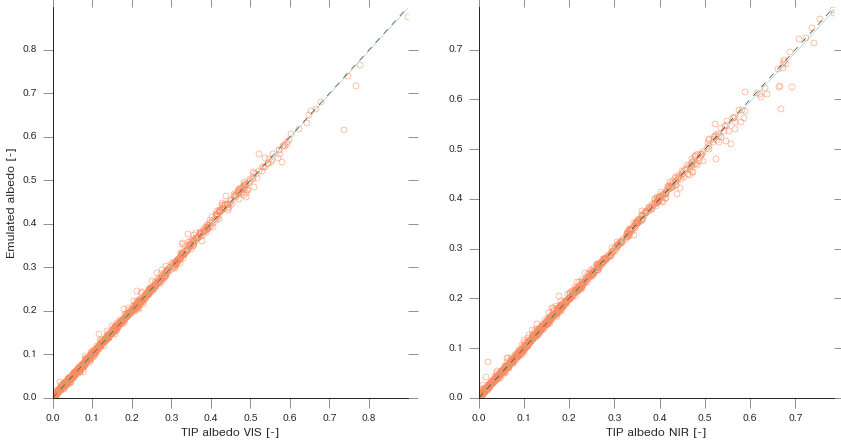

In [4]:
fig, axs = plt.subplots ( nrows=1, ncols=2, figsize=(14,7))
axs = axs.flatten()

print "%6s %6s %12s %6s %6s %6s" % ( "Band", "Slope", "Intercept", "R", "   StdErr", "MAE")
for iband, band_name in enumerate(["VIS", "NIR"]):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs[iband].plot ( validate_output, emulated_validation, 'o', mec="#FC8D62", mfc="none", rasterized=True )
    ymax = np.max ( validate_output.max(), emulated_validation.max() )
    axs[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%6s & %6.3f & %6.3f & %6.3f & %6.3e & %6.3e\\\\" % (band_name, slope, intercept, r_value, std_err, mae),
    x = np.linspace(0, 1.2*ymax, 5)
    axs[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs[iband].set_ylim ( 0, ymax )
    axs[iband].set_xlim ( 0, ymax )
    
    #axs[iband].set_title ( "MODIS Band %d" % (iband+1))
    print
axs[0].set_ylabel ( "Emulated albedo [-]")
axs[0].set_xlabel ( "TIP albedo VIS [-]")
axs[1].set_xlabel ( "TIP albedo NIR [-]")

In [5]:
gp_vis = emulation_test[0][0]
gp_nir = emulation_test[1][0]
val_vis = emulation_test[0][1]
val_nir = emulation_test[1][1]
bhr_vis = emulation_test[0][2]
bhr_nir = emulation_test[1][2]

print val_vis.shape
print bhr_vis.shape

(1000, 7)
(1000,)


In [6]:
def j_obs ( x, albedo_vis, albedo_nir, sigma=0.2 ):
    # Calculate first the uncertainties associated with each measurement. By
    # default, the error is 10% of the signal
    x = np.atleast_2d(x)
    sigma_obs_vis = max ( 2.5e-3, sigma*albedo_vis )
    sigma_obs_nir = max ( 2.5e-3, sigma*albedo_nir )
    
    # forward model the proposal
    model_albedo_vis, vis_var, vis_der = gp_vis.predict ( x )
    model_albedo_nir, nir_var, nir_der = gp_nir.predict ( x )
       
    lklhood =  0.5*( model_albedo_vis - albedo_vis )**2/sigma_obs_vis**2 + \
              0.5*( model_albedo_nir - albedo_nir  )**2/sigma_obs_nir**2
    
    
    der_lklhood = (1./sigma_obs_vis**2)*( model_albedo_vis - albedo_vis )*vis_der + \
        (1./sigma_obs_nir**2)*( model_albedo_nir - albedo_nir )*nir_der 
    return lklhood, der_lklhood.squeeze()

print j_obs ( validate[150,:],the_simulator([validate[150,:],30], band="VIS" ), bhr_nir[150] )


(array([ 0.20859495]), array([ 7.85677339,  0.72668467,  4.83128239, -4.2689174 , -0.05450012,
       -1.52538026, -1.80221737]))


Let's look at LAI transformations. Start by considering (after some tinkering) an exponential transform, and plot the change in VIS and NIR albedo as a function of transformed LAI (remember that high LAI is now close to 0 and low LAI is close to 1):

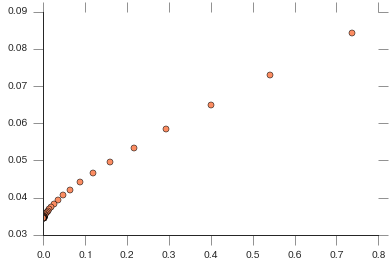

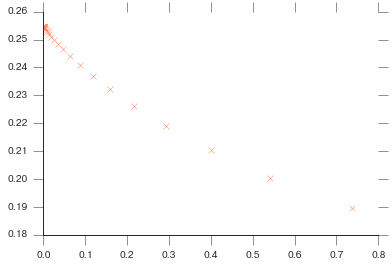

In [7]:
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
r=[]
for lai in np.linspace(0, 10, 50):
    x[-1] = lai
    r.append(two_stream_model ( x, 30 )[0])
plt.plot(np.exp(-np.linspace(0,10,50)*1.5), r, 'o')
plt.figure()
r=[]
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
for lai in np.linspace(0, 10, 50):
    x[-1] = lai
    r.append(two_stream_model ( x, 30 )[1])
plt.plot(np.exp(-np.linspace(0,10,50)*1.5), r, 'x')

In the previous snippet, it would appear that if we transform LAI to $tLAI=\exp\left(-LAI\cdot\frac{3}{2}\right)$ we get something similar to a straight line...

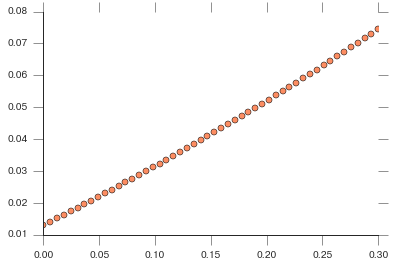

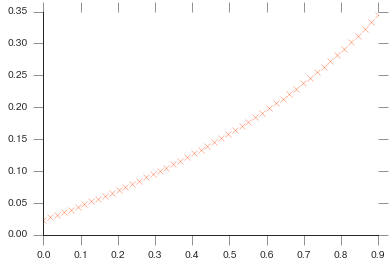

In [8]:
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
r=[]
for lai in np.linspace(0, 0.3, 50):
    x[0] = lai
    r.append(two_stream_model ( x, 30 )[0])
plt.plot(np.linspace(0,0.3,50), r, 'o')
plt.figure()
r=[]
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
for lai in np.linspace(0, 0.9, 50):
    x = np.array ( [0.17, 1., 0.1, lai, 2., 0.18, 1.5 ] )
    r.append(two_stream_model ( x, 30 )[1])
plt.plot(np.linspace(0,0.9,50), r, 'x')

So $\omega_{VIS, NIR}$ is fairly linear (OK, less for NIR as it goes up, but...)

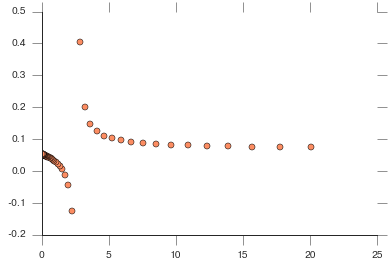

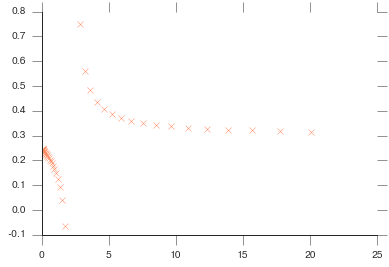

In [9]:
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
r=[]
for lai in np.linspace(-3, 3, 50):
    x = np.array ( [0.17, lai, 0.1, 0.7, 2, 0.18, 1.5 ] )
    r.append(two_stream_model ( x, 30 )[0])
plt.plot(np.exp(-np.linspace(-3,3,50)), r, 'o')
plt.figure()
r=[]
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
for lai in np.linspace(-3, 3, 50):
    x = np.array ( [0.17, 1., 0.1, 0.7, lai, 0.18, 1.5 ] )
    r.append(two_stream_model ( x, 30 )[1])
plt.plot(np.exp(-np.linspace(-3,3,50)), r, 'x')

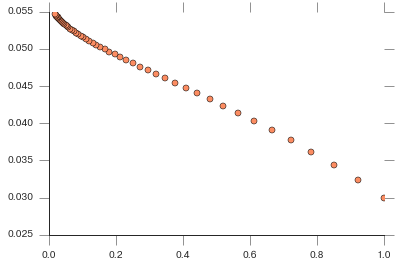

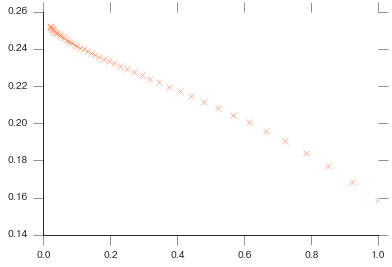

In [10]:
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
r=[]
for lai in np.linspace(0,4, 50):
    x = np.array ( [0.17, lai, 0.1, 0.7, 2, 0.18, 1.5 ] )
    r.append(two_stream_model ( x, 30 )[0])
plt.plot(np.exp(-np.linspace(0,4,50)), r, 'o')
plt.figure()
r=[]
x = np.array ( [0.17, 1., 0.1, 0.7, 2., 0.18, 1.5 ] )
for lai in np.linspace(0, 4, 50):
    x = np.array ( [0.17, 1., 0.1, 0.7, lai, 0.18, 1.5 ] )
    r.append(two_stream_model ( x, 30 )[1])
plt.plot(np.exp(-np.linspace(0,4,50)), r, 'x')

So, some simple linearisations might be useful here... Let's see....

* $TLAI=\exp(-3\cdot LAI/2)$
* $t\Omega=\Omega$ (not much to delinearise about that it would appear...)
* $Td=\exp(-d)$

Next step is to do emulate the TIP under the following assumptions:

1. Linearised parameters
2. Only NIR (... VIS) parameters for NIR (... VIS) albedo

In [11]:
from functools import partial



# The number of training samples and validation samples. For training, you can probably get away with 100, but 150
# is safer
# validation is as many as you can stomach!
n_train = 150
n_validate = 1000

# A wrapper of the 2stream model wrapper to select the band

def the_simulator ( x, band ):
    sun_angle = 0.
    if band.upper() == "VIS":
        omega_vis, td_vis, a_vis, tlai = x[0]
        d_vis = -np.log(td_vis)
        lai = -1.5*np.log(tlai)
        p = np.array( [omega_vis, d_vis, a_vis, 0.0, 0.0,  0.0, lai] )
        return two_stream_model ( p, sun_angle )[0]
    
    elif band.upper() == "NIR":
        omega_nir, td_nir, a_nir, tlai = x[0]
        d_nir = -np.log(td_nir)
        lai = -1.5*np.log(tlai)

        p = np.array ( [ 0.0, 0.0, 0.0, omega_nir, d_nir, a_nir, lai])
        
        return two_stream_model ( p, sun_angle )[1]
    
    

emulation_test = []

# This sets up the model parameters, as well as their min/max boundaries
parameters = {"VIS": ["omega_VIS", "d_VIS", "a_VIS", "LAI"],
              "NIR": ["omega_NIR", "d_NIR", "a_NIR", "LAI"] }
#parameters_vis = 
#parameters_nir = ["omega_NIR", "d_NIR", "a_NIR", "LAI"]
min_vals = np.ones(4)*.001
max_vals = np.ones(4)*0.95

for band in ["VIS", "NIR"]:
    simulator = partial ( the_simulator, band=band )
    xx = gp_emulator.create_emulator_validation (
                simulator, parameters[band], min_vals, max_vals, n_train, n_validate, do_gradient=True, 
                n_tries=15 )
    emulation_test.append ( xx )


After 15, the minimum cost was -5.532943e+02
[9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05]
None
After 15, the minimum cost was -5.590683e+02
[9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05]
None


  Band  Slope    Intercept      R    StdErr    MAE
   VIS &  0.996 &  0.001 &  1.000 & 8.246e-04 & 6.289e-02\\
   NIR &  0.998 &  0.001 &  1.000 & 5.414e-04 & 3.296e-02\\


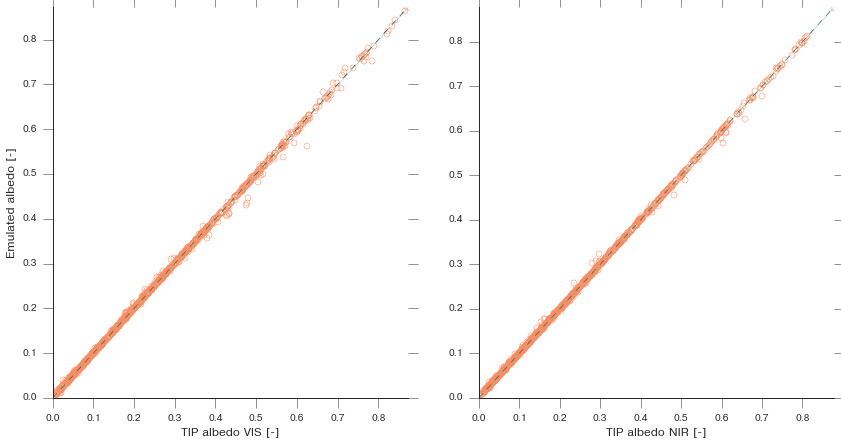

In [12]:
fig, axs = plt.subplots ( nrows=1, ncols=2, figsize=(14,7))
axs = axs.flatten()

print "%6s %6s %12s %6s %6s %6s" % ( "Band", "Slope", "Intercept", "R", "   StdErr", "MAE")
for iband, band_name in enumerate(["VIS", "NIR"]):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs[iband].plot ( validate_output, emulated_validation, 'o', mec="#FC8D62", mfc="none", rasterized=True )
    ymax = np.max ( validate_output.max(), emulated_validation.max() )
    axs[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%6s & %6.3f & %6.3f & %6.3f & %6.3e & %6.3e\\\\" % (band_name, slope, intercept, r_value, std_err, mae),
    x = np.linspace(0, 1.2*ymax, 5)
    axs[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs[iband].set_ylim ( 0, ymax )
    axs[iband].set_xlim ( 0, ymax )
    
    #axs[iband].set_title ( "MODIS Band %d" % (iband+1))
    print
axs[0].set_ylabel ( "Emulated albedo [-]")
axs[0].set_xlabel ( "TIP albedo VIS [-]")
axs[1].set_xlabel ( "TIP albedo NIR [-]")

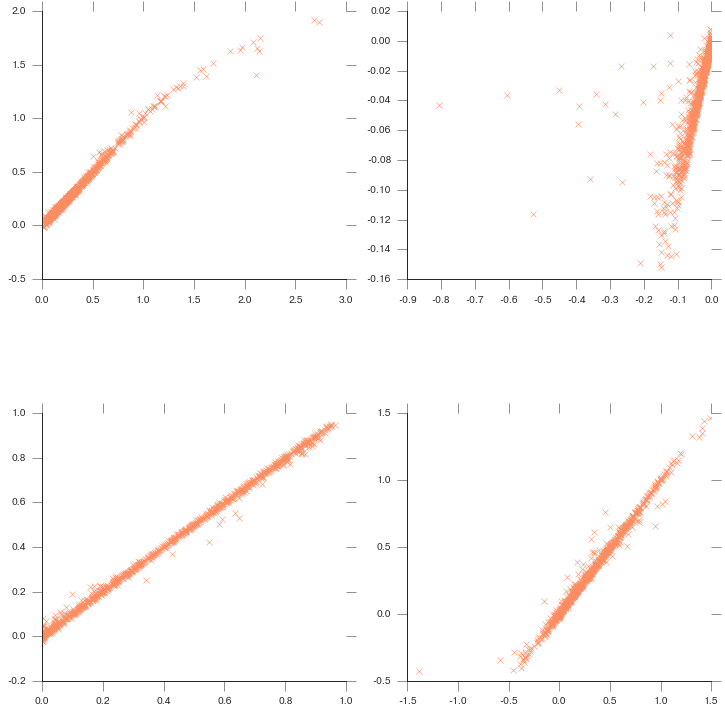

In [13]:
plt.figure(figsize=(12,12))
gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[1]
for i in xrange(4):
    plt.subplot( 2,2,i+1)
    plt.plot ( validate_gradient[:,i], emulated_gradient[:,i], 'x')

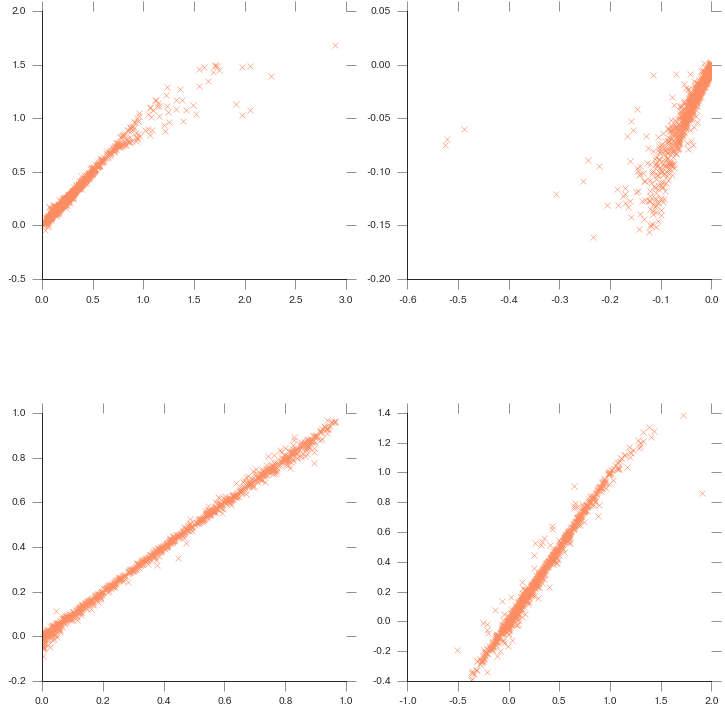

In [14]:
plt.figure(figsize=(12,12))
gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[0]
for i in xrange(4):
    plt.subplot( 2,2,i+1)
    plt.plot ( validate_gradient[:,i], emulated_gradient[:,i], 'x')

In [16]:
import cPickle
cPickle.dump(emulation_test[0][0], open("tip_vis_albedo_transformed.pkl", 'w'), protocol=2 )
cPickle.dump(emulation_test[1][0], open("tip_nir_albedo_transformed.pkl", 'w'), protocol=2 )